# Basics: serine landscape

We will get started by building a very simple fitness landscape, where fitness depends of a nucleotide sequence dependes on whether it codes for Serine or not. Serine is the only aminoacid that is encoded by two sets of mutationally disconnected codons under the standard genetic code (`AGU,AGC` and `UCA,UCC,UCG,UCU`). This leads to a landscape with two isolated fitness peaks that we can easily visualize

## Define a discrete space

The first thing we need to do is to define the discrete space for the evolutionary random walk. While we provide a generic class ``DiscreteSpace`` to define an arbitrary discrete space based on the adjacency matrix and nodes properties on which the transition between states may depend, the class ``SequenceSpace`` has built-in properties and methods specifically for spaces of this kind.

In [39]:
# Import required libraries
from os.path import join

import pandas as pd
import numpy as np
import gpmap.src.plot.mpl as plot

from gpmap.src.genotypes import get_nodes_df_highlight
from gpmap.src.datasets import DataSet
from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWalk

After importing the required libraries, we can read the fitness values that we have previously generated. In this artificial example, we assigned fitnesses in the following way:

| Aminoacid | Fitness $\omega$ |
|---------- |:----------------:|
|  Serine   |         2        |
|   Other   |         1        |
|   Stop    |         0        |

We also added some small perturbation to the fitnesses of the individual codons that could account for codon usage biases or other factors. This will also allow better separation of the genotypes in the low dimensional representation. 

While there are many ways to generate this `SequenceSpace`, we provide a built-in `DataSet` containing such a landscape and that allows an easy interface with other objects in the library as follows

In [40]:
serine = DataSet('serine')
serine.landscape

y
AAA  1.176405
AAC  1.040016
AAG  1.097874
AAT  1.224089
ACA  1.186756
..        ...
TGT  0.963726
TTA  0.932754
TTC  0.964045
TTG  0.918685
TTT  0.827372

[64 rows x 1 columns]

This simple dataframe just stores the function $y_i$ value for each sequence $i$, which is allw we need to create a ``SequenceSpace`` object using the `DataSet.to_sequence_space()` method

In [41]:
space = serine.to_sequence_space()
print(space)

Sequence Space:
	Type: dna
	Sequence length: 3
	Number of alleles per site: [4, 4, 4]
	Genotypes: [AAA,AAC,AAG,...,TTC,TTG,TTT]
	Function y: [1.18,1.04,1.10,...,0.96,0.92,0.83]


or just by creating the `Sequnece` from those values directly

In [42]:
space = SequenceSpace(X=serine.landscape.index.values, y=serine.landscape.y.values)
print(space)

Sequence Space:
	Type: dna
	Sequence length: 3
	Number of alleles per site: [4, 4, 4]
	Genotypes: [AAA,AAC,AAG,...,TTC,TTG,TTT]
	Function y: [1.18,1.04,1.10,...,0.96,0.92,0.83]


## Define a random walk on the discrete space

Once we have defined our discrete space, we just need to define an additional random walk on it. 

In [43]:
rw = WMWalk(space)

### Defining the strength of selection

As shown in the Theory section, this random walk is defined by the discrete space but also by an additional hyperparameter that needs to be defined a priori: the scaled effective population size `Ns`. There are 3 different ways in which we define ``Ns`` for our random walk:
 
 - Directly through the ``Ns`` argument. If we are dealing with fitness directly, then $s=1$ and we can set an estimate of the $N_e$ of the species we are modeling. In some cases, we may even deal the scaled fitness e.g. when derived from stationary frequencies, providing a natural choice of $Ns=1$. 
 - By selecting the expected `mean_function` at stationarity. For instance if we are dealing with experimental data derived from a wild-type sequence, we can assume that the wilde-type phenotype is a good approximation of the expected phenotypic value at stationarity.
 - By selecting the percentile of expected mean function at stationarity among the values of all genotypes (`mean_function_percentile`) if we do not have a very clear reference of what could be a functional phenotype.
 
In this case, lets try with a mean function at stationarity of 1.5, which implies that a substantial probability would lie on the few genotypes with fitness 2 corresponding to the codons encoding Serine. We can later check what ``Ns`` was required to reach that stationary function

In [44]:
rw.set_Ns(mean_function=1.5)
print('Mean function at stationarity of 1.5 was reached at Ns={:.2f}'.format(rw.Ns))

Mean function at stationarity of 1.5 was reached at Ns=2.13


Internally, this computes the sparse rate matrix that defines the random walk and we can compute the stationary frequencies, this is, the fractionof time that the random walk spends in each possible genotype, which span about 2 orders of magnitude due to selection for Serine alone

In [45]:
freqs = rw.calc_stationary_frequencies(Ns=rw.Ns)
print('Stationary frequencies range from {:.5f} to {:.5f}'.format(freqs.min(), freqs.max()))

Stationary frequencies range from 0.00077 to 0.10425


From those frequencies, it is easy to compute the expected fitness under that distribution and verify that it matches the desired one

In [46]:
np.round(rw.calc_stationary_mean_function(freqs), 2)

1.5

### Calculating the coordinates of the visualization

Once the random walk is defined, we can numerically calculate the propertly scaled right eigenvectors of the rate matrix to use as coordinates of our low dimensional representation. We can specify the number of components to compute, which can provide an idea about other slowly decaying modes of the random walk.


In [47]:
rw.calc_visualization(Ns=rw.Ns, n_components=20)

The coordinates of the embeding is stored in the attribute ``nodes_df`` of the `WMWalk` object as a standard pandas ``DataFrame`` object that we can use for plotting

In [48]:
rw.nodes_df.head()

1         2         3         4         5         6         7  \
AAA  0.407809  0.868655  0.077718 -0.881550  0.062912  1.472110 -0.606877   
AAC  0.629546  0.280194 -0.609875  0.203409  0.112413  0.803236 -0.580154   
AAG  0.391836  0.755212  0.062261 -0.091491  1.218855  1.151346 -0.585330   
AAT  0.692524  0.172758  0.678345  0.175420  0.145846  0.818042 -0.591270   
ACA -0.249561  0.195755 -0.026722 -0.982568 -0.188220  0.845132  0.357073   

            8         9        10  ...        13        14        15  \
AAA -0.747799  0.084493  0.925630  ...  0.189047  0.204727  0.305264   
AAC -0.518404  0.318867  0.156468  ...  0.264463  0.597901 -0.411744   
AAG -0.711375  0.023780 -0.164794  ...  0.115422 -0.085225 -1.077083   
AAT -0.594482  0.109683  0.096941  ...  0.798394  0.046978 -0.349036   
ACA -0.301584  0.056766  0.018231  ...  0.620715  0.319452  0.686605   

           16        17        18        19        20  function  \
AAA -1.344604 -0.426318 -1.001960 -0.108886  0.201358  1.176405   
AAC -0.029703  0.110071 -0.028554 -0.282016 -0.546921  1.040016   
AAG -0.223406 -0.330539  0.199638  0.459709 -1.482576  1.097874   
AAT  0.390893 -0.378651 -0.712831  0.331475 -0.495848  1.224089   
ACA  0.043641  0.009723  0.227721 -0.524040  0.930972  1.186756   

     stationary_freq  
AAA         0.013284  
AAC         0.009940  
AAG         0.011241  
AAT         0.014702  
ACA         0.013580  

[5 rows x 22 columns]

Additionally, we can extract the edges as a dataframe for plotting by storing the adjacency relationships between pairs of genotypes. Note that for efficiency we only provide the indexes, so `nodes_df` should remain in the given order for the relationships to be maintained in the plots

In [49]:
edges_df = rw.space.get_edges_df()
edges_df.head()

i  j
0  0  1
1  0  2
2  0  3
3  1  0
4  1  2

## How to plot a landscape visualization

As the output of the visualization is a simple dataframe with the coordinates, it allows plotting with any library or other programming language. However, we also provide some functions to facilitate the user this job using different libraries for different funcitonalities.

The main functions are built using [matplotlib](https://matplotlib.org/) and can be easily used for some basic plots


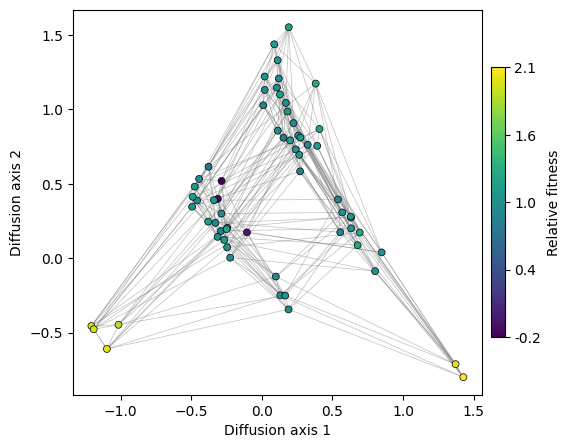

In [50]:
fig, axes = plot.init_fig(1, 1, colsize=6, rowsize=5)
plot.plot_visualization(axes, rw.nodes_df, edges_df=edges_df, x='1', y='2',
                        nodes_lw=0.5,
                        nodes_color='function', nodes_cmap_label='Relative fitness',
                        nodes_size=25, edges_alpha=0.5)

Now that we have a nice visualization of the structure of the landscape, we can easily see the main qualitative properties of this simple landscape: it consists of two main fitness peaks that are separated appart from each other along Diffusion axis 1. Diffusion axis 2 separates genotypes with high fitness from those with low fitness that are at an increasing number of mutations away from any of the two fitness peaks. 

We can look at other Diffusion axis as easily as shown below

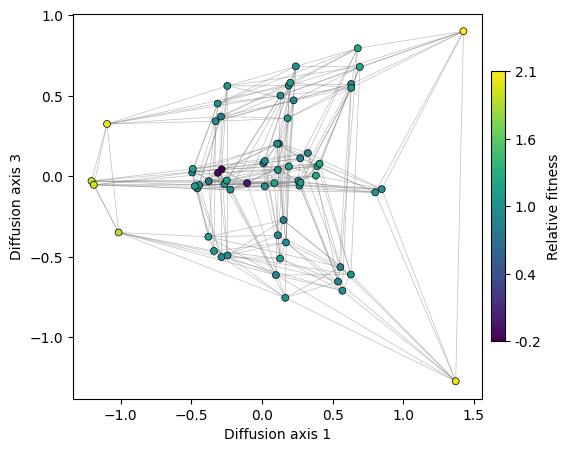

In [51]:
fig, axes = plot.init_fig(1, 1, colsize=6, rowsize=5)
plot.plot_visualization(axes, rw.nodes_df, edges_df=edges_df, x='1', y='3',
                        nodes_lw=0.5,
                        nodes_color='function', nodes_cmap_label='Relative fitness',
                        nodes_size=25, edges_alpha=0.5)

Thus, we can see that Diffusion axis 3 shows the variability within each of the fitness peaks. The two genotypes in the AGY peak are more separated than those at the UCN fitness peak containing 4 sequences. This is because we can only move through the small peak by the single mutation that connects the two genotypes, while the remaining mutations are deleterious. In contrast, any mutation in the last base of the genotypes at the big peak is neutral, as they keep coding for Serine. Thus, as there are many more ways to evolve from one to another, the required time for that to happen is also shorter.

## How many dimensions to plot?

A natural question in any dimensionality reduction method, such as this or Principal Component Analysis (PCA) is: how many dimensions do we need to retain the most relevant information in the data? In other words, how can we reasonably choose the number of dimensions to represent our data?

In this section we will discuss a few non-exclusive approaches to determine the number of relevant dimensions or Diffusion axes to represent and the rationale behind them

### Explore relaxation times associated to the diffusion axes

In PCA, the eigenvalues of the covariance matrix are related to the variance explained by each component of the low dimensional representation. Thus, we can look at those relative contributions and choose the number of axes that retain a reasonably high % of total variance that is still tractable. In our case, the eigenvalues $\lambda_k$ for the rate matrix $\mathbf{Q}$ represent the decay rates associated to the different components. We are interested in the components that decay particularly slowly, as they represent different barriers to difusion that depend only on the structure of the fitness landscape. Thus, instead of looking at the variance explained by each component, we can represent the average relaxation time $\left(\frac{1}{-\lambda_k}\right)$ associated to each component for increasingly large $k$'s.

Note that the relaxation times have units of expected number of substitutions.


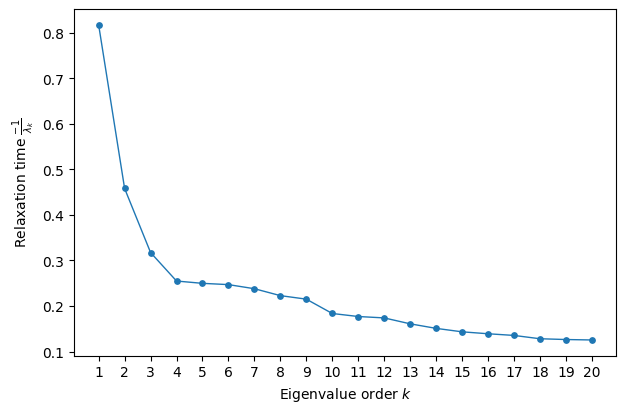

In [52]:
fig, axes = plot.init_fig(1, 1, colsize=7, rowsize=4.5)
plot.plot_relaxation_times(rw.decay_rates_df, axes=axes)

Here, we can see how the 3 first axes, but specially the first, stand out over the others, which are much more similar to each other. In other words, the decay rates associated to components $k>4$ are on the same fast scale and therefore are not likely to represent modes with long lasting effects on the approach to stationarity. 

### Look for a large eigengap

An alternative approach to select the relevant number of dimensions consists on looking for an eigengap, this is, a sudden change in the eigenvalues (or relaxation times in this case) compared to the variability between consecutive eigenvalues before and after the gap. 

In this case, we can see that the largest gap is found between dimensions 1 and 2. In fact, although we have seen that dimensions 2 and 3 capture some relevant details about the geometry of the landscape, dimension 1 alone is sufficient to separate the 2 main fitness peaks of our landscape.

### Compare with the relaxation time under neutral evolution

In our case, we can not only compare the time scales associated to the different components, but we also have an absolute reference time scale to compare with: that of the neutral process. Thus, we are mostly interested in components that decay slower than the slowest component of the neutral evolutionary dynamics. If there are not mutational biases, then the neutral relaxation rate is equal to the reciprocal of the number of alleles per site ($\alpha=4$ in our case)

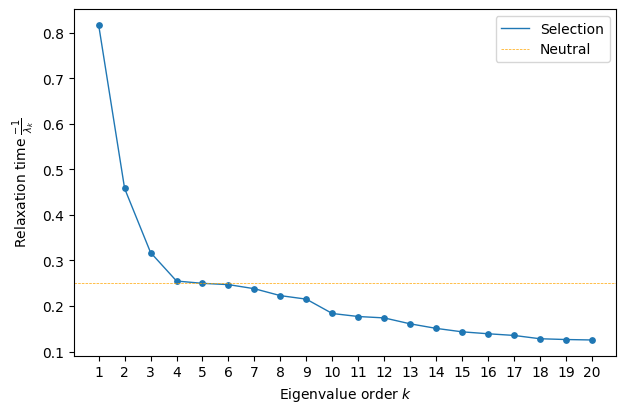

In [53]:
fig, axes = plot.init_fig(1, 1, colsize=7, rowsize=4.5)
plot.plot_relaxation_times(rw.decay_rates_df, axes=axes, neutral_time=1/4.)

Now, we can see that only the first 3 components decay significantly slower than the neutral evolution, suggesting that the main features of the serine landscape are well captured by a 3-dimensional representation

## Exploring different selection strengths

So far, we have used the strength of selection `Ns` as a hyperparemeter that needs to be appropriately set a priori. However, rather than trying to generate the one and true visualization, it can be useful to think about a one-dimensional family of visualizations spanning the whole possible range of selection strengths: from neutral evolution to a regime with very strong selection, in which the population spends all the time in the fittest genotype.

To do so, we need to recalculate the embedding for the different panels, so it is a more computationally expensive plot to do. We need to provide the plotting function `figure_Ns_grid` with a `RandomWalk` object, so that the function iterates over a reasonable or user provided range of population sizes

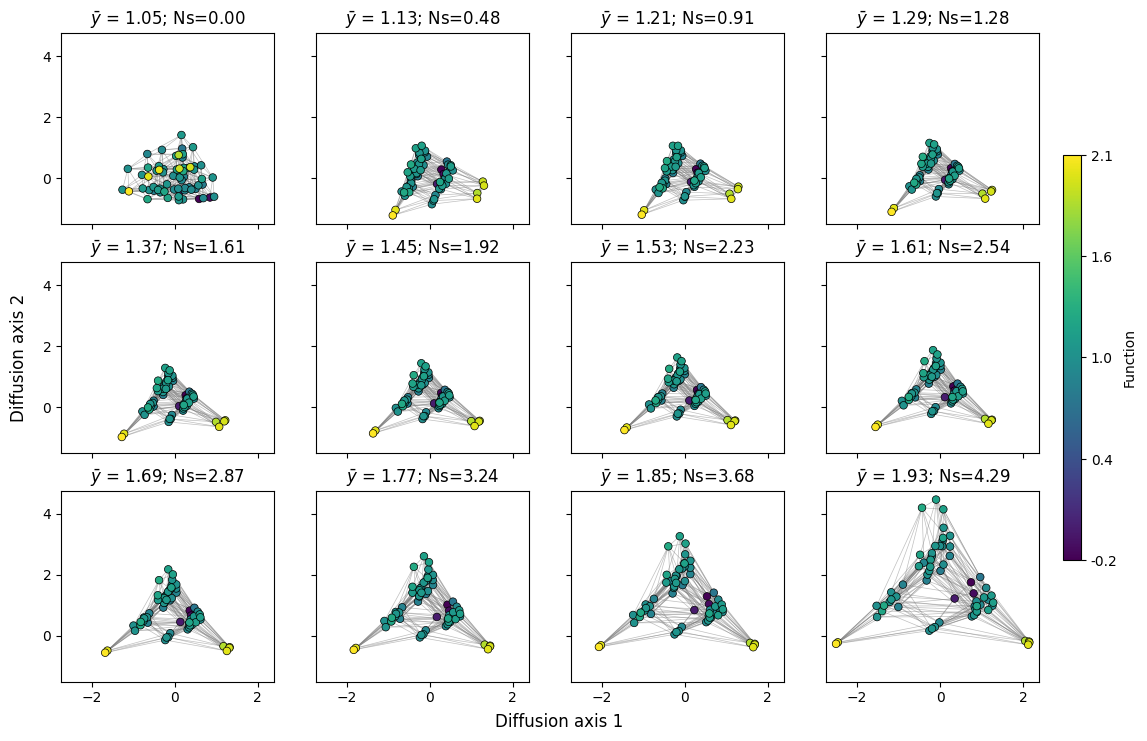

In [54]:
plot.figure_Ns_grid(rw, nodes_color='function', pmin=0, pmax=0.8,
                    nodes_size=30, edges_alpha=0.5, nodes_lw=0.5)

Here, we can easily see the effect of selection strength or population size on the dynamics of evolutionary process, pulling appart some genotypes and increasing the time required to evolve from some genotypes to others. As selection strength increases, deleterious mutations are less likely to fix in the population and therefore we need more time to cross a fitness valley. Despite the very regular connected nature of sequence space shown under neutral evolution, the landscape becomes increasingly disconnected and highligths finer details of its geometry as selection kicks in.

We can also see how the relaxation time of the different components change with population size

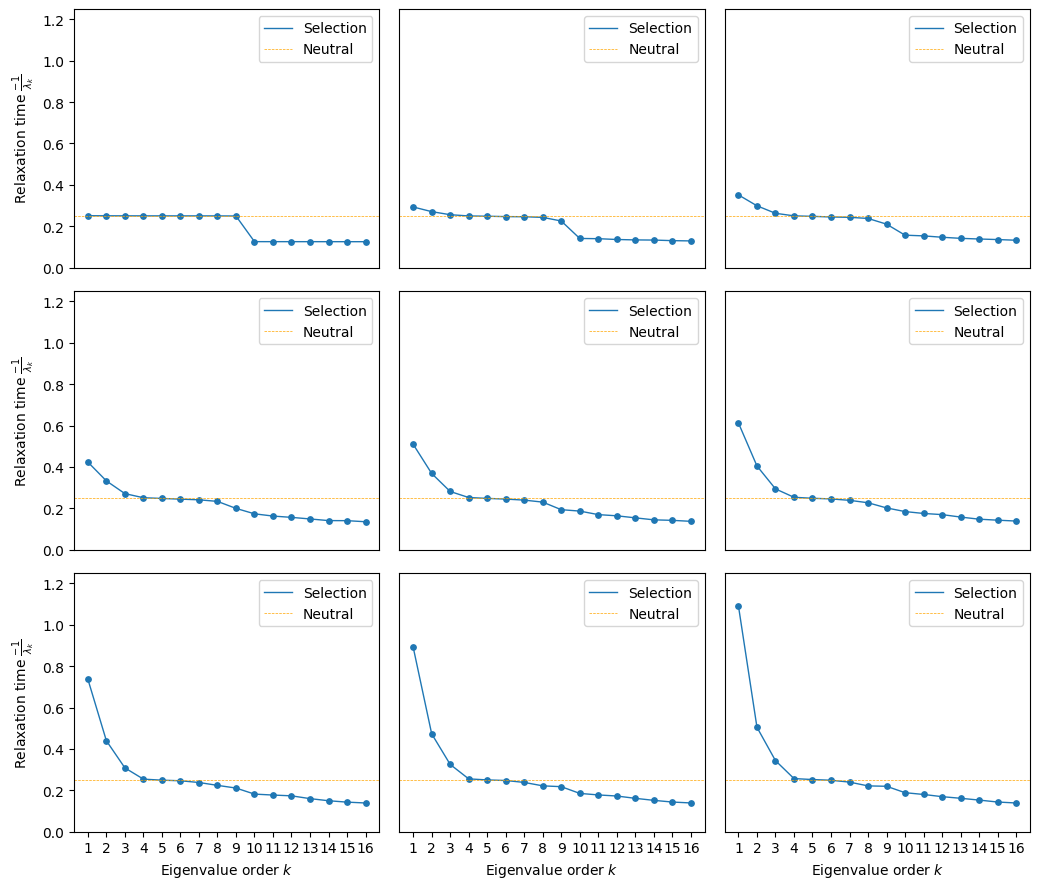

In [55]:
mean_functions = np.linspace(1.05, 1.6, 9)

fig, subplots = plot.init_fig(3, 3, colsize=3.5, rowsize=3)
subplots = subplots.flatten()

for i, (axes, mean_function) in enumerate(zip(subplots, mean_functions)):
    rw.calc_visualization(mean_function=mean_function, n_components=16)
    plot.plot_relaxation_times(rw.decay_rates_df, axes=axes,
                               neutral_time=1/4.)
    
    axes.set_ylim((0, 1.25))
    if i not in [0, 3, 6]:
        axes.set(ylabel='', yticks=[])
    if i < 6:
        axes.set(xlabel='', xticks=[])
    
fig.tight_layout()

We can see that at low population sizes the first 9 components have virtually the same contribution, which is inherent to a uniform random walk on sequence space with 4 alleles and 3 sites. As selection starts to act, we can see how the relaxation time associated to the first component increases, since crossing the valley between the two peaks becomes harder and harder. 

## How to characterize peaks

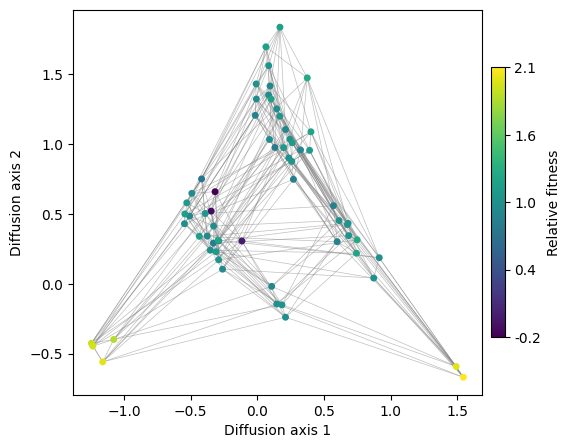

In [56]:
fig, axes = plot.init_fig(1, 1, colsize=6, rowsize=5)
plot.plot_visualization(axes, rw.nodes_df, edges_df=edges_df, x='1', y='2',
                        nodes_color='function', nodes_cmap_label='Relative fitness',
                        nodes_size=25, edges_alpha=0.5)

Now we have a nice visualization of the structure of the landscape, where we can see two main fitness peaks that are separated appart from each other along diffusion axis 1, while diffusion axis 2 separates genotypes with high fitness from those with low fitness that are at an increasing number of mutations away. 

The natural question now is: what are the sequences at the different fitness peaks? A simple approach to that question is to color genotypes systematically according their sequence or subsequence, which we can do if we have some guess about the nature of the fitness peaks. In this case we do have a very reasonable guess, which is the two isolated sets of codons that encode Serine, so we can highlight directly those sets of sequences and see where they lay in the embedding. We provide an utility function `get_nodes_df_highlight` to take a subset of genotypes from the `nodes_df` dataframe with an additional column with the annotated sets of genotypes, in this case usign IUPAC motifs.

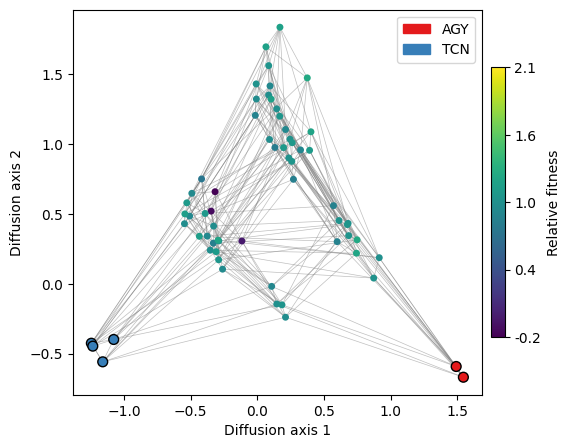

In [57]:
df = get_nodes_df_highlight(rw.nodes_df, genotype_groups=['TCN', 'AGY'])
plot.plot_nodes(axes, df, color='group', x='1', y='2', size=50, palette='Set1', lw=1)
fig

We can indeed see that the peaks correspond to the different sets of codons that code for the Serine aminoacid. However, in a real scenario, we would rarely know beforehand what sequences compose the different fitness peaks. A useful strategy is to make a series of plots in which we serially color by the alleles at each position. This way, we can follow how a genotype or group of genotypes lights up in each position for the different alleles, so we can effectively read the sequence features that characterize a region of the visualization from this layout easily.

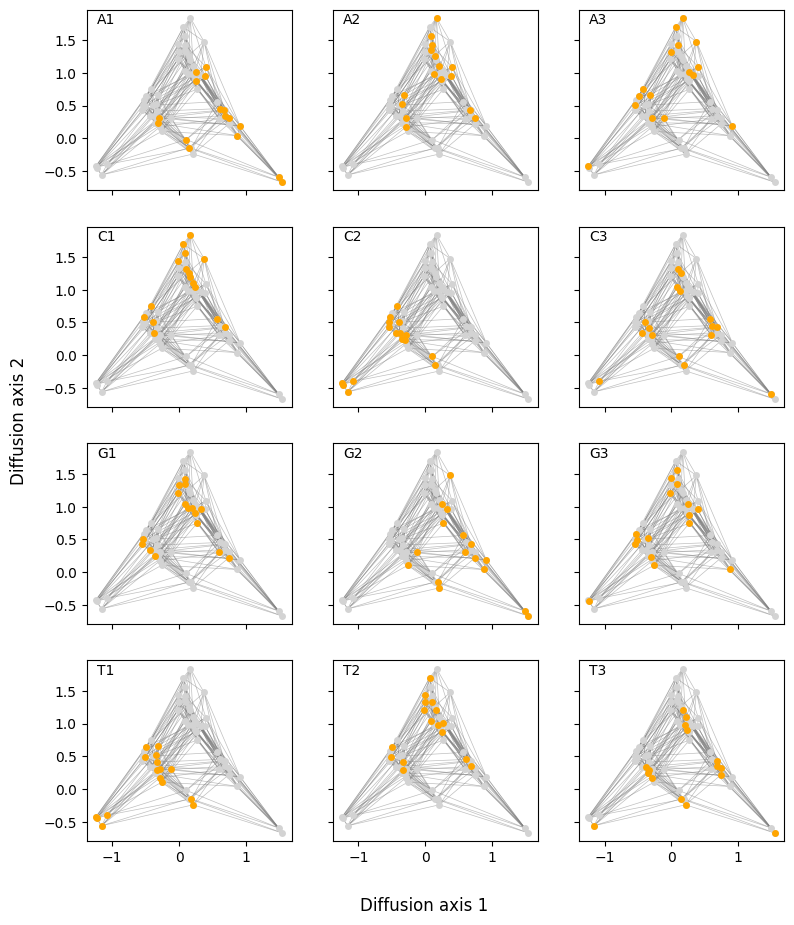

In [58]:
plot.figure_allele_grid(rw.nodes_df, edges_df=edges_df, x='1', y='2',
                        nodes_size=25, edges_alpha=0.5)

We can see that plotting different versions of the same landscape can be very useful, in this case for reading the sequence of each genotype in the plot. However, it can be a good strategy to overlay other information e.g. we can compute the effect of a single mutation across all possible genetic backgrounds and color the visualization by it to track how the effect of this particular mutation changes in the different regions of the landscape

## Advanced plots

In this section, we will expand on the possibilities of the plotting functions implemented

- More customized plots using [matplotlib](https://matplotlib.org/)
- Interactive plots in standard html format using [plotly](https://plotly.com/python/)
- Efficient plotting of particularly large landscapes (over 1M genotypes), when rendering by standard libraries becomes too costly, using [datashader](https://datashader.org/)

### Customize plots in matplotlib

We have previously generated simple plots using a high level function that took care of plotting everything. However, the plotting is internally divided into two basic and flexible functions, which allow us to build more complex plots.

- nodes plotting
- edges plotting

For plotting the nodes, we just need to provide the dataframe `nodes_df` with the embedding and specify which dimensions we want to show and what we want to color by, as well as other classical parameters as size or edge color and width, as in a regular scatterplot.

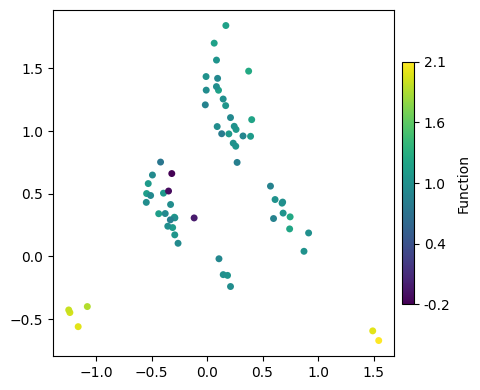

In [59]:
fig, axes = plot.init_fig(1, 1, colsize=5, rowsize=4.5)
plot.plot_nodes(axes, rw.nodes_df, x='1', y='2', color='function', size=25)

We can either color by a column in the `dataframe` or specify a fixed color. The same goes for the node size

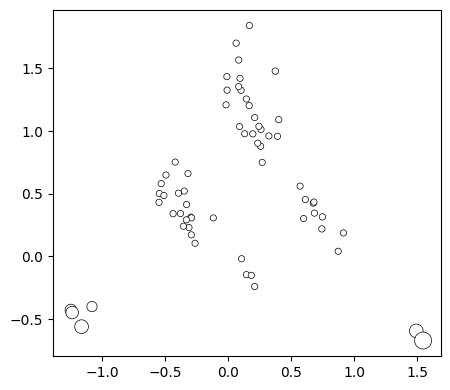

In [60]:
fig, axes = plot.init_fig(1, 1, colsize=5, rowsize=4.5)
plot.plot_nodes(axes, rw.nodes_df, x='1', y='2', color='white', size='stationary_freq',
                edgecolor='black', lw=0.5, min_size=20, max_size=150)

Now we can easily add the edges to show how genotypes are connected to each other by single point mutations

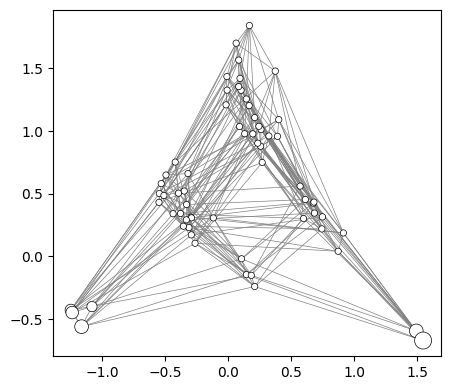

In [61]:
plot.plot_edges(axes, rw.nodes_df, edges_df=edges_df, alpha=1)
fig

### 3D visualization

As we have recalculated the diffusion axes for plotting the decay of relaxation times, our `RandomWalk` object now contains the embedding calculated under the strongest selective regime, which will allow us to see finer details of the fitness peaks when looking at more diffusion axis. 

We can generate a 3D plot by just specifying which axis is shown in the `z` argument, by default set to `None` to do 2D representations. 

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

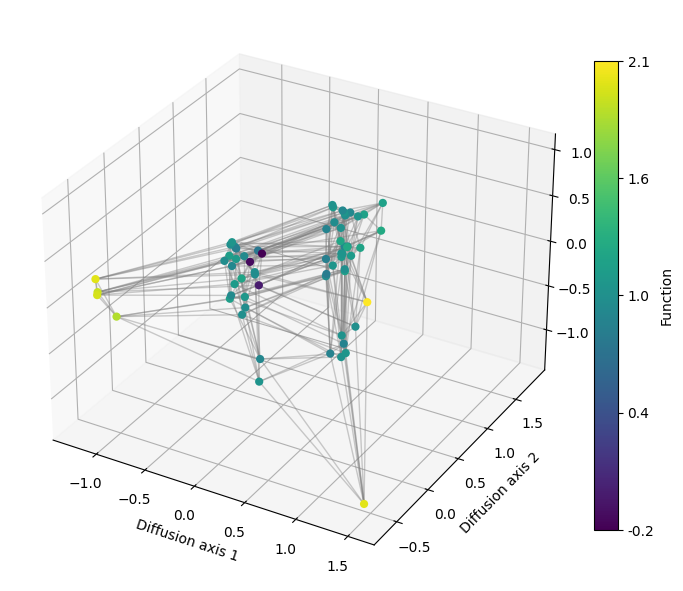

In [63]:
fig = plt.figure(figsize=(7, 7))
axes = fig.add_subplot(111, projection='3d')
plot.plot_visualization(axes, rw.nodes_df, edges_df=edges_df,
                        x='1', y='2', z='3', nodes_color='function',
                        nodes_size=35, edges_width=1, edges_alpha=0.4)

fig.tight_layout()

### Interactive visualization

We can use [plotly](https://plotly.com/python/) to generate interactive visualizations where we can zoom in and out, show the genotypes on the nodes when hovering over them with the mouse, and rotating to have different views when having a 3D plot

In [64]:
import gpmap.src.plot.ply as plot

In [65]:
fig = plot.plot_visualization(rw.nodes_df, edges_df=edges_df,
                              nodes_color='function', nodes_size=10, edges_width=1)
fig.show('notebook')

In [66]:
fig = plot.plot_visualization(rw.nodes_df, edges_df=edges_df, z='3',
                             nodes_color='function', nodes_size=4, edges_width=1)
fig.show('notebook')